# Team Choice Algorithm
In this notebook, we are going to build an algorithm that selects the optimal team (i.e. highest points with the 100M budget) based on already predicted points from our internal and/or external Machine Learning models. This will be a zero-one knapsack algorithm that has to fulfil the following constraints:
- Choose **15 players** where ***2 are goalkeepers***, ***5 are defenders***, ***5 are midfielders***, and ***3 are strikers***
- Your 15-player choice should **NOT include** more than 3 players from the same team
- Maximise the points for **11 players eligible to play** per gameweek where ***1 is a goalkeeper***, ***3-5 are defenders***, ***3-5 are midfielders***, and ***1-3 are strikers***
- Note players on the bench will be included if one eligible player is injured/does not play in a gameweek
- You can make one transfer every gameweek and this can be carried forward but never exceeds 2 free transfers. All additional transfers cost 4 points on your gameweek score

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

In [62]:
predictions = pd.read_csv("../data/predictedpoints.csv")
print(predictions.shape)
predictions.head()

(701, 29)


,ID,Name,Team,Pos,Price,17_pts_no_prob,17_prob,17_with_prob,18_pts_no_prob,18_prob,...,21_with_prob,22_pts_no_prob,22_prob,22_with_prob,23_pts_no_prob,23_prob,23_with_prob,24_pts_no_prob,24_prob,24_with_prob
0,1,Fábio Vieira,ARS,MID,5.4,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2,G.Jesus,ARS,FWD,6.7,1.83597,0.84527,1.55190,1.97640,0.84527,...,1.55897,1.92377,0.84527,1.62611,1.96467,0.84527,1.66068,1.69913,0.84527,1.43623
2,3,Gabriel,ARS,DEF,6.2,3.12473,0.93607,2.92496,2.93571,0.93607,...,2.84085,2.95557,0.93607,2.76661,3.12157,0.93607,2.92200,2.96097,0.93607,2.77167
3,4,Havertz,ARS,FWD,7.9,2.79984,0.88851,2.48768,3.05553,0.88851,...,2.57413,2.98151,0.88851,2.64910,2.91123,0.88851,2.58665,2.75344,0.88851,2.44645
4,5,Hein,ARS,GK,4.0,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [63]:
start_gw = 17 #Enter the starting gameweek for your team selection
gw_count = 5 #Up to how many gameweeks in the future would you like to consider

## Compute the total expected points for the next gw_count weeks  the starting gameweek
predictions['total_pts'] = predictions[str(start_gw) + '_pts_no_prob']
predictions['total_prob'] = predictions[str(start_gw) + '_prob']
for gw in range(start_gw+1,start_gw+gw_count):
    predictions['total_pts'] += predictions[str(gw) + '_pts_no_prob']
    predictions['total_prob'] *= predictions[str(gw) + '_prob']

predictions = predictions[predictions.total_pts != 0] #Drop all players with 0 expected points
predictions = predictions[predictions.total_prob >= 0.3] #Drop all players with a high likelyhood to miss
predictions['pts_per_price'] = predictions['total_pts']/predictions['Price'] #Compute total points per price
print(predictions.shape)
predictions.tail()

(247, 32)


,ID,Name,Team,Pos,Price,17_pts_no_prob,17_prob,17_with_prob,18_pts_no_prob,18_prob,...,22_with_prob,23_pts_no_prob,23_prob,23_with_prob,24_pts_no_prob,24_prob,24_with_prob,total_pts,total_prob,pts_per_price
634,635,El Khannouss,LEI,MID,4.8,2.79021,0.81715,2.28003,2.10145,0.81715,...,2.05328,2.29763,0.81715,1.87751,2.23799,0.81715,1.82878,12.04901,0.364342,2.510210
641,642,André,WOL,MID,5.0,2.26880,0.83104,1.88546,2.11291,0.83104,...,1.69902,2.03094,0.83104,1.68780,2.13709,0.83104,1.77601,10.80757,0.396378,2.161514
649,650,Lacroix,CRY,DEF,4.5,2.69355,0.87146,2.34733,2.86554,0.87146,...,2.64187,2.72251,0.87146,2.37257,3.00503,0.87146,2.61878,13.97054,0.502617,3.104564
650,651,Mangala,EVE,MID,5.0,1.96181,0.93707,1.83836,1.95214,0.93707,...,1.88343,2.04533,0.93707,1.91662,2.19689,0.93707,2.05864,10.01323,0.722537,2.002646
651,652,Ugarte,MUN,MID,4.9,2.60354,0.85169,2.21741,2.18687,0.85169,...,2.08368,2.06664,0.85169,1.76014,2.50619,0.85169,2.13450,11.77399,0.448134,2.402855


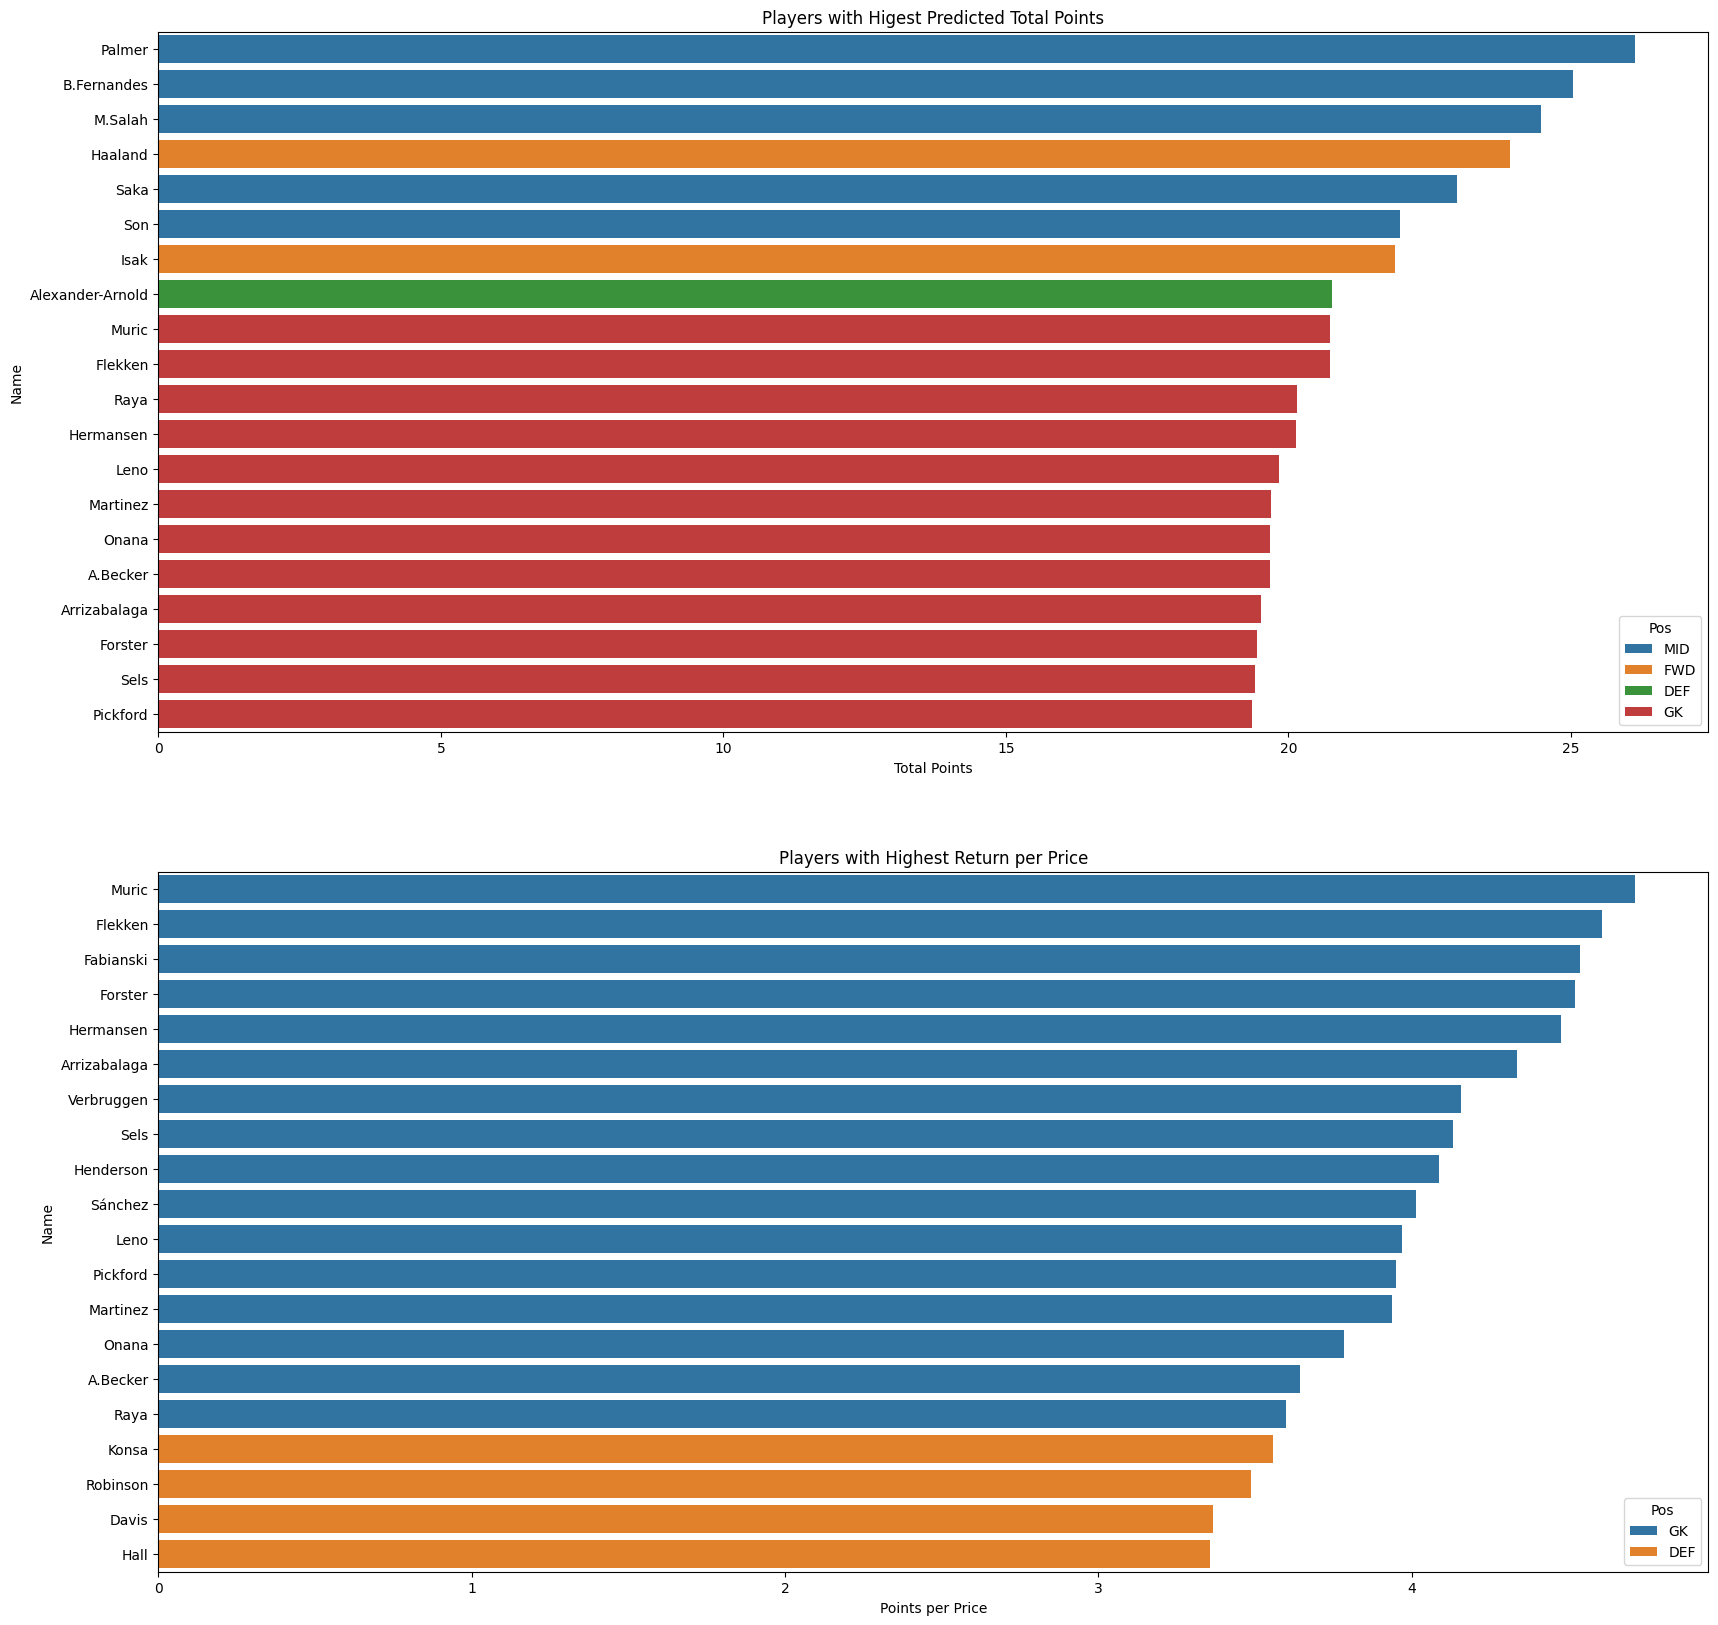

In [59]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.barplot(predictions.sort_values(by='total_pts',ascending=False)[:20],x='total_pts',y='Name',hue='Pos',native_scale=True)
plt.title("Players with Higest Predicted Total Points")
plt.xlabel('Total Points')

plt.subplot(2,1,2)
sns.barplot(predictions.sort_values(by='pts_per_price',ascending=False)[:20],x='pts_per_price',y='Name',hue='Pos',native_scale=True)
plt.title("Players with Highest Return per Price")
plt.xlabel("Points per Price")

plt.show()

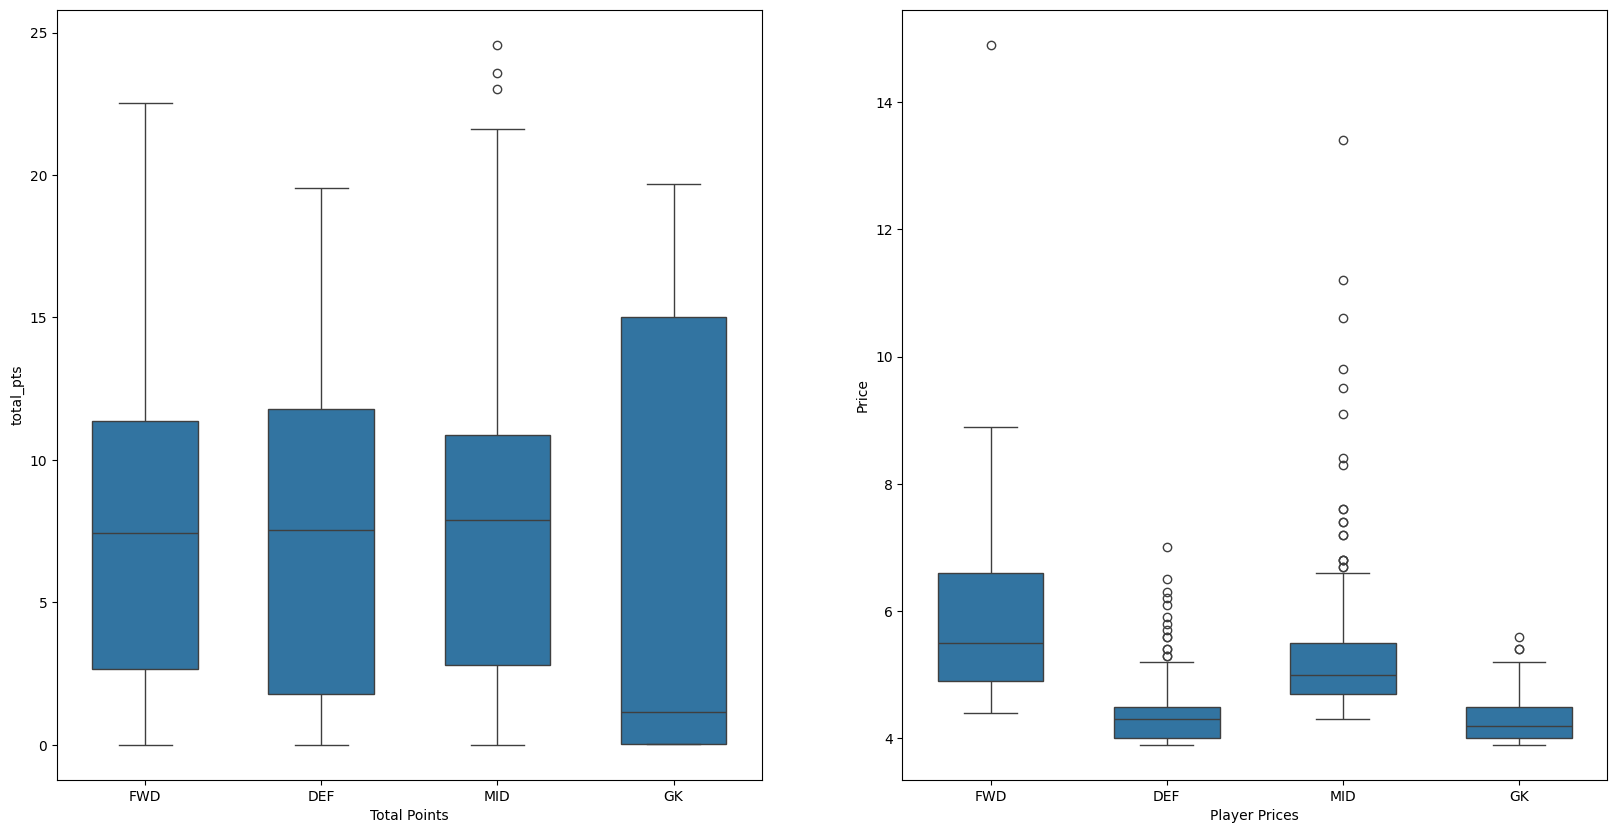

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.boxplot(data=predictions,y='total_pts',x='Pos', hue_order=['GK','DEF','MID','FWD'], gap=0.25,native_scale=True)
plt.xlabel('Total Points')

plt.subplot(1,2,2)
sns.boxplot(data=predictions,y='Price',x='Pos', hue_order=['GK','DEF','MID','FWD'], gap=0.25,native_scale=True)
plt.xlabel('Player Prices')

plt.show()

## Zero-One Knapsack Algorithm

### Determining budget per player type

In [60]:
def generatebudget(df,position,price_cname='Price',position_cname='Pos', n_players = {'GK':2,'DEF':5,'MID':5,'FWD':3}):
    target = n_players[position]

    prices = df[price_cname][df[position_cname]==position].sort_values()

    min_budget = 0
    for i in range(target):
        min_budget += prices.iloc[i]

    max_budget = 0
    for i in range((-1*target),0):
        max_budget += prices.iloc[i]

    return min_budget, max_budget, target #minimum budget, maximum budget, target number of players


generatebudget(df=predictions, position = 'MID')

(22.4, 54.49999999999999, 5)

### 0-1 Knapsack (Maximising points return for a set positional budget)

In [16]:
cache = dict() ## (budget, prices): whatever the knapsack computes
def knapsack(budget, ids, prices, points, choices):
    ##Base Cases
    if choices == 0:
        return (0,[])
    if choices == 1:
        if len(ids) == 0:
            return (float('-inf'),[])
        if len(ids) == 1:
            return (float('-inf'),[]) if prices[0] > budget else (points[0],[ids[0]])
    if choices > 1 and len(ids) <= 1:
        return (float('-inf'),[])

    ## Retrieve from precomputed responses
    if (budget,tuple(ids),choices) in cache.keys():
        return cache[(budget,tuple(ids),choices)]

    ### Repetitive Subproblem
    if prices[-1] > budget:
        cache[(budget,tuple(ids),choices)] = knapsack(budget, ids[:-1], prices[:-1],points[:-1],choices)
        return cache[(budget,tuple(ids),choices)]
    else:
        a = knapsack(budget, ids[:-1],prices[:-1],points[:-1],choices)  #ignore the last item
        b = knapsack(budget-prices[-1],ids[:-1],prices[:-1],points[:-1],choices-1) #include the last item
        
        if a[0] >= b[0]+points[-1]:
            cache[(budget,tuple(ids),choices)] = a
        else:
            cache[(budget,tuple(ids),choices)] = (b[0]+points[-1],b[1]+[ids[-1]])
            
        return cache[(budget,tuple(ids),choices)]
    

knapsack(budget=8,ids=[0,1,2,3],prices=[1,3,5,7],points=[2,4,7,10],choices=2)

(12, [0, 3])

### Determining the returns for every budget across a budget range

In [21]:
def chooseplayers(df, position, min_, max_, target, price_cname='Price', position_cname='Pos', pts_cname='total_pts', id_cname='ID'):
    budgets = list(np.arange(min_,max_+0.1,0.1))

    players = df[[id_cname,price_cname,pts_cname]][df[position_cname]==position]
    returns = list() ## 2D array with every row as budget,return,players

    for budget in budgets:
        budget = round(budget,1)
        budget_return,players_chosen = knapsack(budget, ids=list(players[id_cname]), prices=list(players[price_cname]), points=list(players[pts_cname]), choices=target)
        returns.append([budget,budget_return,players_chosen])

    return returns

### Final 0-1 Knapsack for choosing optimal budget for each player type

In [18]:
memo = dict() ##
def finalknapsack(budget,points_grid,prices_grid,players_grid):
    ## Base cases
    if budget == 0:
        return [0,[]] if len(prices_grid) == 0 else [float('-inf'),[]]
    if len(prices_grid) == 0:
        return [0,[]]
    if len(prices_grid[0]) == 0:
        return [float('-inf'),[]]
                
    ## Retrieve solutions from the memo
    if (budget,len(prices_grid), len(prices_grid[0])) in memo.keys():
        return memo[(budget,len(prices_grid),len(prices_grid[0]))]
    
    ## Repetitive sub-problem
    if prices_grid[0][0] > budget:
        points_grid[0] = points_grid[0][1:]
        prices_grid[0] = prices_grid[0][1:]
        players_grid[0] = players_grid[0][1:]
        memo[(budget,len(prices_grid), len(prices_grid[0]))] = finalknapsack(budget,points_grid,prices_grid,players_grid)
        return memo[(budget,len(prices_grid), len(prices_grid[0]))]
    else:
        a = finalknapsack(budget-prices_grid[0][0],points_grid[1:],prices_grid[1:],players_grid[1:])
        c = [points_grid[0][0],[players_grid[0][0]]]

        points_grid[0] = points_grid[0][1:]
        prices_grid[0] = prices_grid[0][1:]
        players_grid[0] = players_grid[0][1:]
        b = finalknapsack(budget,points_grid,prices_grid,players_grid)

        if a[0] + c[0] >= b[0]:
            memo[(budget,len(prices_grid), len(prices_grid[0]))] = [a[0]+c[0],a[1]+c[1]]
            return memo[(budget,len(prices_grid), len(prices_grid[0]))]
        else:
            memo[(budget,len(prices_grid), len(prices_grid[0]))] = b
            return memo[(budget,len(prices_grid), len(prices_grid[0]))]

### Generating Final Team
1. Choose players (maximising the points return) for each position based on all possible budgets: **InitialKnapsackAlgorithm
    - Goalkeepers: 2 players
    - Defenders: 5 players
    - Midfielders: 5 players
    - Forwards: 3 players
2. Create dataframes for each position with data on each possible budget, the points return, and the players chosen.
    - Minimise the data by eliminating all budgets returning similar point returns (retain the lowest budget)
    - Eliminate all instances where the return is `-inf` i.e. no possible player choice
3. Choose final team by maximising the points return for the full team based on data from (1) which has been cleaned based on (2). **#FinalKnapsackAlgorithm 

In [64]:
min_,max_,target = generatebudget(predictions, position='GK',n_players={'GK':1})
goalkeepers = pd.DataFrame(chooseplayers(df=predictions,position='GK',min_=min_,max_=max_,target=target),columns=['price','points','players'])
goalkeepers = goalkeepers.groupby(by='points').min()
goalkeepers = goalkeepers.reset_index()
goalkeepers = goalkeepers[goalkeepers.points != float('-inf')]
goalkeepers.head()

,points,price,players
0,18.60698,4.1,[521]
1,19.44147,4.3,[488]
2,20.73060,4.4,[568]


In [65]:
min_,max_,target = generatebudget(predictions, position='DEF',n_players={'DEF':3})
defenders = pd.DataFrame(chooseplayers(df=predictions,position='DEF',min_=min_,max_=max_,target=target),columns=['price','points','players'])
defenders = defenders.groupby(by='points').min()
defenders = defenders.reset_index()
defenders = defenders[defenders.points != float('-inf')]
defenders.head()

,points,price,players
0,36.37948,12.0,"[307, 455, 630]"
1,36.83693,12.1,"[291, 455, 630]"
2,38.52987,12.3,"[231, 455, 630]"
3,40.66441,12.4,"[44, 455, 630]"
4,43.08959,12.8,"[44, 85, 630]"


In [66]:
min_,max_,target = generatebudget(predictions, position='MID',n_players={'MID':4})
midfielders = pd.DataFrame(chooseplayers(df=predictions,position='MID',min_=min_,max_=max_,target=target),columns=['price','points','players'])
midfielders = midfielders.groupby(by='points').min()
midfielders = midfielders.reset_index()
midfielders = midfielders[midfielders.points != float('-inf')]
midfielders.head()

,points,price,players
0,36.28451,17.8,"[111, 285, 608, 619]"
1,37.56997,18.0,"[111, 285, 410, 608]"
2,39.67265,18.1,"[111, 239, 285, 608]"
3,42.88371,18.3,"[94, 111, 608, 619]"
4,44.16917,18.5,"[94, 111, 410, 608]"


In [67]:
min_,max_,target = generatebudget(predictions, position='FWD',n_players={'FWD':3})
forwards = pd.DataFrame(chooseplayers(df=predictions,position='FWD',min_=min_,max_=max_,target=target),columns=['price','points','players'])
forwards = forwards.groupby(by='points').min()
forwards = forwards.reset_index()
forwards = forwards[forwards.points != float('-inf')]
forwards.head()

,points,price,players
1,25.55653,14.8,"[27, 289, 470]"
2,28.13243,14.9,"[27, 289, 453]"
3,31.75959,15.3,"[27, 252, 289]"
4,33.27478,15.5,"[27, 232, 453]"
5,34.18519,15.6,"[27, 252, 453]"


In [72]:
points_grid = [list(goalkeepers.points),list(defenders.points),list(midfielders.points),list(forwards.points)]
prices_grid = [list(goalkeepers.price),list(defenders.price),list(midfielders.price),list(forwards.price)]
players_grid = [list(goalkeepers.players),list(defenders.players),list(midfielders.players),list(forwards.players)]

result = finalknapsack(100-(4.4 + 4.3 + 4.5 + 4.5),points_grid,prices_grid,players_grid)
print(result)

[221.08830999999998, [[232, 252, 401], [17, 182, 366, 503], [18, 255, 311], [568]]]


In [38]:
4.4+4.4+7+4.8+4.3+4.8+4.6+9.8+10.6+10.8+8.4+4.5+5.5+5.5+8.8+1.1+(11.2-10.8)

99.70000000000002

In [73]:
player_ids = list()
for i in result[1]:
    for j in i:
        player_ids.append(j)

predictions['chosen'] = predictions.ID.isin(player_ids)
predictions[predictions['chosen']== True]

,ID,Name,Team,Pos,Price,17_pts_no_prob,17_prob,17_with_prob,18_pts_no_prob,18_prob,...,23_pts_no_prob,23_prob,23_with_prob,24_pts_no_prob,24_prob,24_with_prob,total_pts,total_prob,pts_per_price,chosen
16,17,Saka,ARS,MID,10.6,4.07760,0.94106,3.83728,5.29515,0.94106,...,4.76606,0.94106,4.48516,4.32012,0.94106,4.06550,22.97596,0.738051,2.167543,True
17,18,Saliba,ARS,DEF,6.3,3.72445,0.91592,3.41128,3.51961,0.91592,...,3.73557,0.91592,3.42147,3.40130,0.91592,3.11531,18.30506,0.644596,2.905565,True
181,182,Palmer,CHE,MID,11.2,4.87783,0.94054,4.58779,5.80640,0.94054,...,4.10361,0.94054,3.85961,6.27934,0.94054,5.90597,26.12633,0.736014,2.332708,True
231,232,Ndiaye,EVE,FWD,5.4,2.52767,0.93871,2.37273,2.29047,0.93871,...,2.54691,0.93871,2.39080,2.99227,0.93871,2.80886,12.81913,0.728882,2.373913,True
251,252,Raúl,FUL,FWD,5.5,2.95750,0.93485,2.76481,2.41290,0.93485,...,2.67747,0.93485,2.50302,2.45797,0.93485,2.29782,13.72954,0.714019,2.496280,True
254,255,Robinson,FUL,DEF,4.8,3.23352,0.94123,3.04350,3.40584,0.94123,...,3.19159,0.94123,3.00403,3.43580,0.94123,3.23389,16.73231,0.738718,3.485898,True
310,311,Alexander-Arnold,LIV,DEF,7.0,4.18810,0.94036,3.93832,4.58891,0.94036,...,4.08106,0.94036,3.83765,3.82775,0.94036,3.59946,20.76528,0.735310,2.966469,True
365,366,B.Fernandes,MUN,MID,8.4,4.94242,0.94121,4.65187,4.95893,0.94121,...,4.86993,0.94121,4.58364,5.23666,0.94121,4.92881,25.03908,0.738640,2.980843,True
400,401,Isak,NEW,FWD,8.7,3.80774,0.94057,3.58145,4.77062,0.94057,...,4.82361,0.94057,4.53694,4.92469,0.94057,4.63201,21.88833,0.736132,2.515900,True
502,503,Son,TOT,MID,9.8,4.48902,0.94199,4.22860,3.92844,0.94199,...,5.79242,0.94199,5.45639,4.15604,0.94199,3.91494,21.97669,0.741705,2.242519,True


In [31]:
final_df = pd.concat([predictions[predictions.ID == result[1][-1][0]],predictions[predictions.ID == result[1][-1][1]]])

for i in range(len(result[1])-1):
    for j in range(len(result[1][i])):
        final_df = pd.concat([final_df,predictions[predictions.ID == result[1][i][j]]])


final_df

IndexError: list index out of range